## Filtrage exponentiel de l'image

Filtre exponentiel : On crée un noyau basé sur la distance, qui applique un flou progressif.

Convolution : Chaque pixel de l'image est filtré en utilisant ce noyau.

Résultat : L'image filtrée devient plus lisse et moins bruyante.

Le filtre permet de réduire le bruit tout en préservant les détails principaux de l'image.


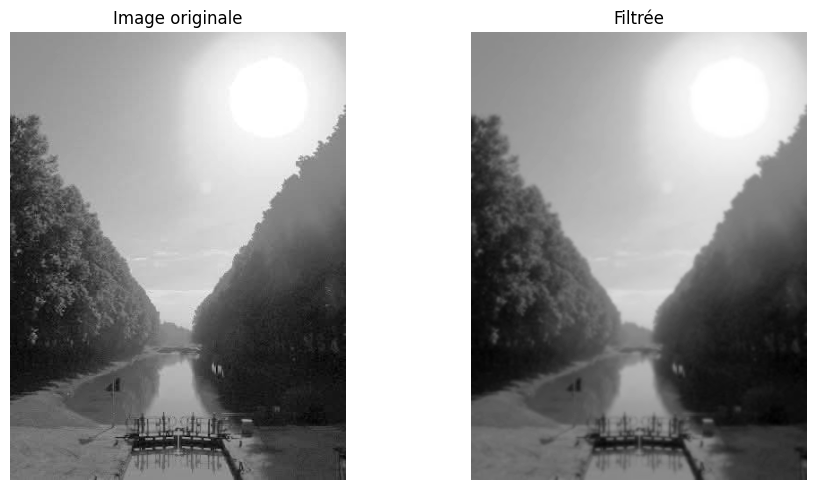

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def create_exponential_kernel(size=5, alpha=1.0):
    k = size // 2
    x, y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    distance = np.sqrt(x**2 + y**2)
    kernel = np.exp(-alpha * distance)
    kernel /= kernel.sum()
    return kernel

def apply_convolution(image, kernel):
    image_h, image_w = image.shape
    kernel_size = kernel.shape[0]
    k = kernel_size // 2
  
    output = np.zeros_like(image, dtype=float)
  
    padded = np.pad(image, pad_width=k, mode='edge')
   
    for i in range(image_h):
        for j in range(image_w):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            value = np.sum(region * kernel)
            output[i, j] = value

    output = np.clip(output, 0, 255).astype(np.uint8)
    return output


image = Image.open(r'C:\Users\DELL\Desktop\img1.jpg')
im = image.convert('L')  
image_np = np.array(im)

kernel = create_exponential_kernel(size=7, alpha=1.0)

# Appliquer la convolution
filtered_image = apply_convolution(image_np, kernel)

# Affichage
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Filtrée")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## Filtrage de Wiener sur une image bruitée

L'image est d'abord convertie en niveaux de gris.

On utilise la transformée de Fourier (FFT) pour travailler dans le domaine fréquentiel.

On simule un flou avec un noyau (PSF)=kernel, de taille 3×3.

Le filtre de Wiener est appliqué pour :

Réduire le bruit,
Restaurer l’image en inversant partiellement les effets du flou.

Résultat : une image plus nette, avec moins de bruit que l'image d'origine.


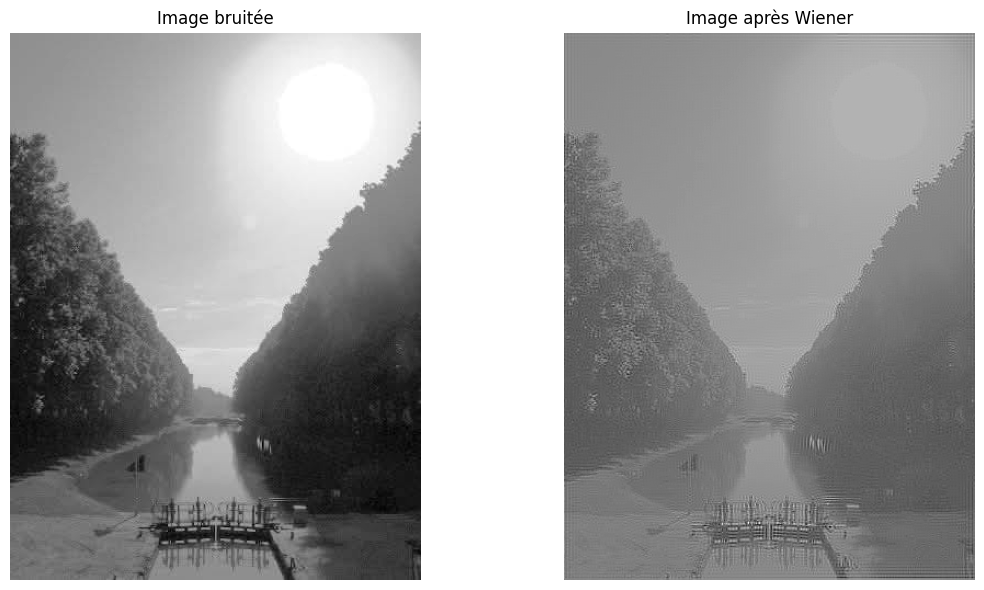

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d

image_path = r"C:\Users\DELL\Desktop\img1.jpg" 
image = Image.open(image_path)

image_gray = image.convert('L')

image_gray = np.array(image_gray)

def wiener_filter(image, noise_var=0.01, signal_var=1):
    image_f = np.fft.fft2(image)
    
    psf = np.ones((3, 3)) / 9  # Point Spread Function (PSF) pour simuler un flou
    psf_f = np.fft.fft2(psf, s=image.shape)  # FFT du noyau

    psf_f_conj = np.conj(psf_f)
    numerator = psf_f_conj * image_f
    denominator = np.abs(psf_f) ** 2 + (noise_var / signal_var)
    
    image_restaurée_f = numerator / denominator
    image_restaurée = np.fft.ifft2(image_restaurée_f).real
    
    return image_restaurée

image_restaurée = wiener_filter(image_gray, noise_var=0.01, signal_var=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title("Image bruitée")
axes[1].imshow(image_restaurée, cmap='gray')
axes[1].set_title("Image après Wiener")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Filtrage médian sur une image

On charge l'image en niveaux de gris.

On applique plusieurs fois un filtre médian de taille 3×3.
    
Le filtre médian sert à réduire le bruit sans trop flouter les contours.
    
Plus on applique le filtre, plus l'image devient lisse.


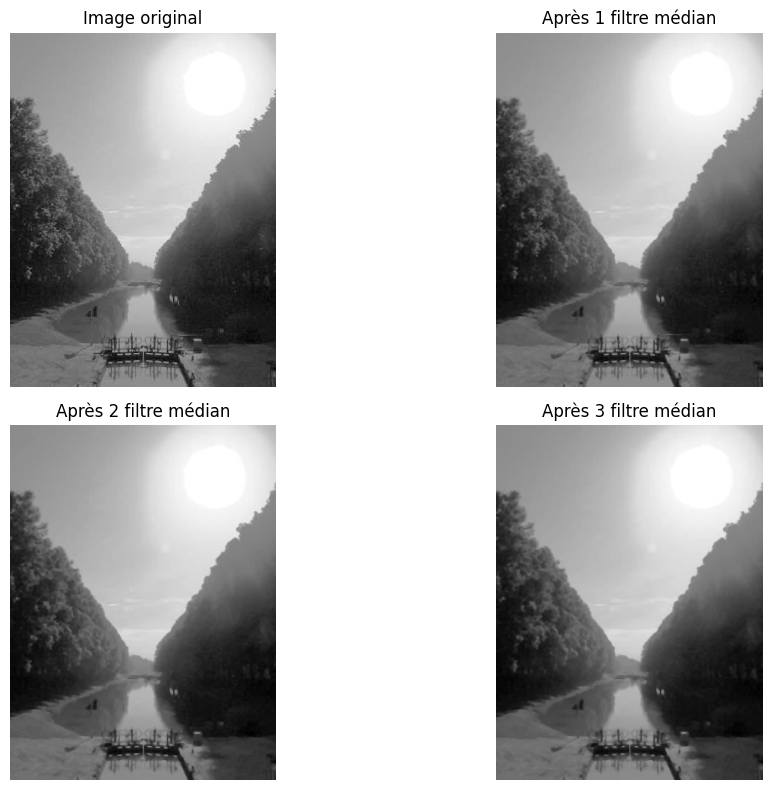

In [13]:
from PIL import Image
import numpy as np
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

image_path = r"C:\Users\DELL\Desktop\img1.jpg" 
img = Image.open(image_path).convert('L')  

image_array = np.array(img, dtype=np.float32)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title("Image original")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

filtered_image = image_array.copy()
for i in range(1, 4):
    filtered_image = median_filter(filtered_image, size=3, mode='reflect')

    plt.subplot(2, 2, i + 1)
    plt.title(f"Après {i} filtre médian")
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Détection de contours avec Kirsch et seuillage

On charge l'image en noir et blanc.

On applique les 8 filtres de Kirsch (dans toutes les directions).

On garde la valeur maximale pour chaque pixel.

On applique un seuil : seuls les pixels au-dessus sont gardés.

Le résultat montre les contours forts de l'image.


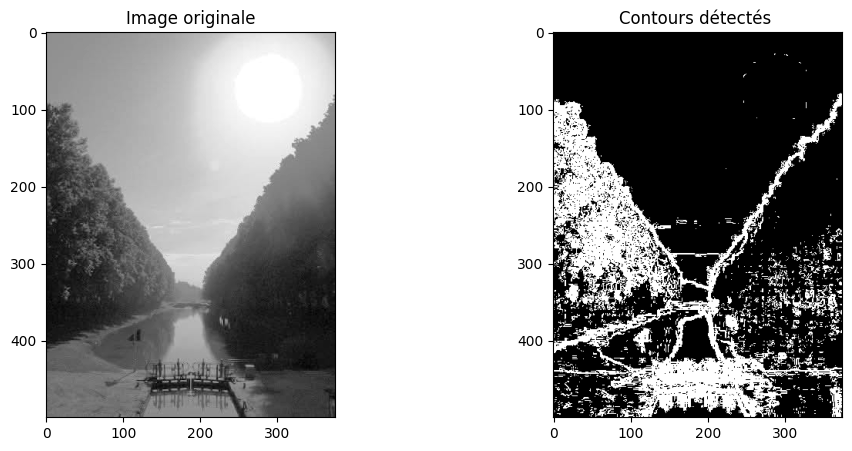

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image en niveaux de gris
image = cv2.imread(r'C:\Users\DELL\Desktop\img1.jpg', cv2.IMREAD_GRAYSCALE)

# Définir les masques de Kirsch
kirsch_kernels = [
    np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),
    np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]),
    np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]),
    np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]),
    np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]),
    np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]),
    np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]),
    np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]])
]

# Appliquer les filtres de Kirsch
responses = [cv2.filter2D(image, -1, kernel) for kernel in kirsch_kernels]
kirsch_edge = np.maximum.reduce(responses)

# Appliquer un seuil
threshold_value = 100
_, binary_mask = cv2.threshold(kirsch_edge, threshold_value, 255, cv2.THRESH_BINARY)

# Afficher
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Contours détectés ')
plt.imshow(binary_mask, cmap='gray')
plt.show()


##  la segmentation de limage

On détecte les contours avec les filtres de Kirsch.

On applique un seuil pour créer un masque binaire ,Le masque binaire permet de sélectionner uniquement les zones utiles de l'image (comme les contours) et d'ignorer le reste.

Le masque sert à séparer les objets du fond.

On garde seulement les zones utiles grâce à ce masque.

Résultat : une image segmentée contenant les contours.


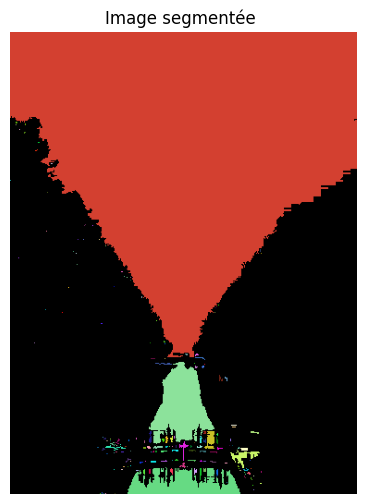

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
image = cv2.imread(r"C:\Users\DELL\Desktop\img1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convertir en gris et appliquer un seuillage pour créer un masque binaire
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, binary_mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Trouver les contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Créer une image vide pour dessiner les segments colorés
segmented_colored = np.zeros_like(image)

# Attribuer une couleur aléatoire à chaque segment
for i, cnt in enumerate(contours):
    color = tuple(np.random.randint(0, 256, size=3).tolist())  # Couleur aléatoire RGB
    cv2.drawContours(segmented_colored, [cnt], -1, color, thickness=cv2.FILLED)

# Afficher l'image segmentée colorée
plt.figure(figsize=(6, 6))
plt.imshow(segmented_colored)
plt.axis('off')
plt.title("Image segmentée ")
plt.show()
